### Recommender Systems on E-commerce
A **recommender system (RS)** helps users that have no sufficient competence or time to evaluate the potentially overwhelming, number of alternatives offered by a web site.

–In their simplest form, RSs recommend to their users personalized and **ranked lists of items.**

The Value of Recommendation System

* Recommendations are responsible for 70% of the time people spend watching videos on YouTube.
* 75% of what people are watching on Netflix comes from recommendations, according to McKinsey.
* 35% of the purchases on Amazon are the result of their recommender system, according to McKinsey.

In this notebook, we will be implementing recommendation model to recommend product to user by using E-commerce data that has 3.265.689 rows and 3 columns applied to 377.716 user and 1.166 product. 

In [46]:
# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)pip install -U scikit-learn
import matplotlib.pyplot as plt
import seaborn as sns
import time
# Classifier Libraries
# Other Libraries
from sklearn.model_selection import train_test_split

# MLflow
import mlflow
from collections import defaultdict

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate

In [47]:
df=pd.read_csv('transaction_data.csv')

In [48]:
df.head()

,customer_id,product_code,total_transaction
0,761d182e-c7e0-4ecf-bb9a-43fe7f0b11e5,10010091,12
1,5ada9e19-ffe0-4c94-a568-790a3aed5a8f,10019615,7
2,052b8ddd-c82a-4f00-be30-8f02bc4ca25e,20098000,7
3,8902401b-caad-4613-912f-4a81ea0c683a,20108987,6
4,75de52e4-f13f-494b-880a-e0daf9fac99f,10000426,10


#### Section 1 - Exploratory Data Analysis (EDA)

Before going into the nuts and bolts of the Recommender systems, let's first take a look at the data and perform some Exploratory Data Analysis. This would help us to truly understand what the data contains and help us create a better model.

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265689 entries, 0 to 3265688
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   customer_id        object
 1   product_code       int64 
 2   total_transaction  int64 
dtypes: int64(2), object(1)
memory usage: 74.7+ MB


In [50]:
print("number of unique customer : ",df["customer_id"].nunique())
print("number of unique product : ",df["product_code"].nunique())


number of unique customer :  377716
number of unique product :  1166


We can see that the data contains 3.265.689  rows and 3 columns where each record contains information about user transaction to the corresponden product.

In [51]:
# just to make sure that all Nan containing rows are deleted..
print("No of Nan values in our dataframe : ", sum(df.isnull().any()))

No of Nan values in our dataframe :  0


In [52]:
dup_bool = df.duplicated(['customer_id','product_code','total_transaction'])
dups = sum(dup_bool) # by considering all columns..( including timestamp)
print("There are {} duplicate rating entries in the data..".format(dups))

There are 0 duplicate rating entries in the data..


<AxesSubplot: xlabel='total_transaction', ylabel='count'>

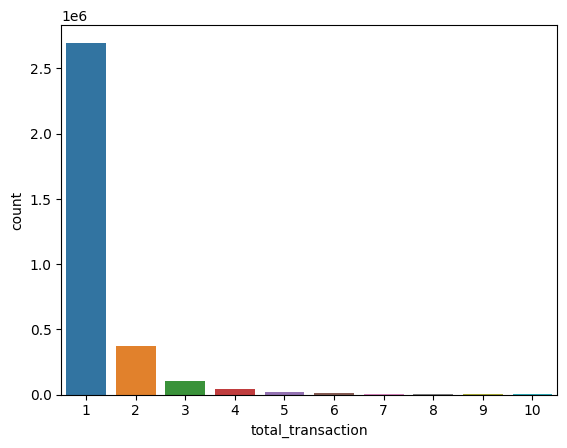

In [53]:
sns.countplot(x="total_transaction",data=df,order=df.total_transaction.value_counts().iloc[:10].index)

##### Data Preprocessing

we will remove the hyphen on the customer_id so that python can easily recognize the customer id variable.

In [54]:
def remove_strip(x:pd.Series)->pd.Series:
    x=x.replace("-","",regex=True)
    return x

df['customer_id']=remove_strip(df['customer_id'])

#### Section 2 - Build Popularity Recommender model. (Non-personalised)

We can see that the data now looks a lot cleaner and is so much easier to understand. Now that we are done with the data exploration and feature finalization, we can proceed with the creation of the Recommender Systems. Before we get into the weeds of the major recommender systems, I would like to give a brief intro to a basic recommender system that doesn't require any models - Popular Recommender System. It is a type of recommendation system which works on the principle of popularity and or anything which is in trend. These systems check about the product which are in trend or are most popular among the users and directly recommend those.

In [55]:
#Split the training and test data in the ratio 70:30
train_data, test_data = train_test_split(df, test_size = 0.3, random_state=0)
print("data train sample : ")
print(train_data.head(5))
print("===="*22)
print("train data shape : ",train_data.shape)
print("test data shape : ",test_data.shape)

data train sample : 
                              customer_id  product_code  total_transaction
985986   8e356c74afee47dbb5e36b04477bb77d      10022534                  1
947486   daf02f7024054e20960630b10c11f2f8      20116675                  1
1112096  04bc52b9ce1f4f69933d2c5ceca71f0d      20115959                  1
1119563  57a0549f84944b63bbd537302fa057f0      20001061                  1
2246695  34ab6e558cbb42f9b5e42a8c732ede05      20070539                  2
train data shape :  (2285982, 3)
test data shape :  (979707, 3)


In [56]:
train_data_grouped = train_data.groupby('product_code').agg({'customer_id': 'count'}).reset_index()
train_data_grouped.rename(columns={'customer_id':'score'},inplace=True)
train_data_grouped.head()

,product_code,score
0,10000019,2217
1,10000103,1362
2,10000104,1664
3,10000120,891
4,10000128,1506


In [57]:
#sort product popularity based on score(total transaction per product_code)
train_data_sort=train_data_grouped.sort_values(by="score",ascending=False)
train_data_sort['rank']=train_data_sort['score'].rank(ascending=0, method='first')
train_data_sort


,product_code,score,rank
75,10003517,40850,1.0
172,10008989,37395,2.0
179,10010805,32719,3.0
217,10021010,28502,4.0
32,10000442,22268,5.0
...,...,...,...
715,20073950,297,1162.0
67,10003333,286,1163.0
978,20104300,241,1164.0
530,20043389,233,1165.0


In [58]:
#get the top 7 recomendation
popularity_recomendation=train_data_sort.head(7)
popularity_recomendation

,product_code,score,rank
75,10003517,40850,1.0
172,10008989,37395,2.0
179,10010805,32719,3.0
217,10021010,28502,4.0
32,10000442,22268,5.0
92,10003974,22068,6.0
259,10036631,21720,7.0


In [59]:
# Use popularity based recommender model to make predictions
def popular_recommend(customer_id):
  user_recommendations=popularity_recomendation

  #Add user_id column for which the recommendations are being generated 
  user_recommendations['customer_id'] = customer_id 

  #Bring user_id column to the front 
  cols = user_recommendations.columns.tolist() 
  cols = cols[-1:] + cols[:-1] 
  user_recommendations = user_recommendations[cols] 
          
  return user_recommendations 

In [60]:
find_recom = ["75de52e4f13f494b880ae0daf9fac99f"]   # This list is user choice.
for i in find_recom:
    print("Here is the recommendation for the userId: ",i)
    print(popular_recommend(i))    
    print("\n") 

Here is the recommendation for the userId:  75de52e4f13f494b880ae0daf9fac99f
                          customer_id  product_code  score  rank
75   75de52e4f13f494b880ae0daf9fac99f      10003517  40850   1.0
172  75de52e4f13f494b880ae0daf9fac99f      10008989  37395   2.0
179  75de52e4f13f494b880ae0daf9fac99f      10010805  32719   3.0
217  75de52e4f13f494b880ae0daf9fac99f      10021010  28502   4.0
32   75de52e4f13f494b880ae0daf9fac99f      10000442  22268   5.0
92   75de52e4f13f494b880ae0daf9fac99f      10003974  22068   6.0
259  75de52e4f13f494b880ae0daf9fac99f      10036631  21720   7.0




C:\Users\ACER\AppData\Local\Temp\ipykernel_8428\3975206772.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_recommendations['customer_id'] = customer_id


#### Section 3 - Model Based System

It is a type of recommendation system which works on the principle of popularity and or anything which is in trend. These systems check about the product or movie which are in trend or are most popular among the users and directly recommend those. Conveniently, Surprise provides several algorithms to develop collaborative filtering recommender systems, starting from memory-based method (i.e. K-Nearest Neighbors or KNN) to model-based method (SVD, SVD++, NMF, Slope one etc.)

Firstly, using the Surprise library, we will benchmark all the algorithms present to see how they perform

#### Data Loading

First we need to define a Reader object to parse the file or the dataframe by Surprise. After that we need to load our dataframe using load_from_df. Use this if you want to use a custom dataset that is stored in a pandas dataframe.
Lastly, build_full_trainset() method builds the training set from the entire data set. 

In [61]:
reader=Reader(rating_scale=(0,10))
data=Dataset.load_from_df(df[["customer_id","product_code","total_transaction"]],reader)

In [62]:
"""
# Iterating over all algorithms

from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering

benchmark = []

for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
""" 

"\n# Iterating over all algorithms\n\nfrom surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering\n\nbenchmark = []\n\nfor algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:\n    # Perform cross validation\n    results = cross_validate(algorithm, data, measures=['RMSE', 'MAE'], cv=5, verbose=False)\n    \n    # Get results & append algorithm name\n    tmp = pd.DataFrame.from_dict(results).mean(axis=0)\n    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))\n    benchmark.append(tmp)\n    \npd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   \n"

SVD++ get the best score among other algorithm. We will do hyperparameter tuning to reach the best perfomance.

**singular value decomposition (SVD)** algorithm One of the popular algorithms to factorize a matrix is the. SVD came into the limelight when matrix factorization was seen performing well in the Netflix prize competition. Other algorithms include PCA and its variations, NMF, and so on.


The SVD has a lot of parameters. The most important ones are:

* n_factors, which controls the dimension of the latent space (i.e. the size of the vectors 
 and 
). Usually, the quality of the training set predictions grows with as n_factors gets higher.
* n_epochs, which defines the number of iteration of the SGD procedure.
* lr_all is the learning rate for all parameters, which is a parameter that decides how much the parameters are adjusted in each iteration.
* reg_all is the regularization term for all parameters, which is a penalty term added to prevent overfitting.

Formally, SVD is decomposition of a matrix R into the product of three matrices:

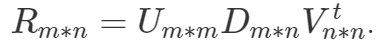

Where 
R Denotes the utility matrix with n equal to the number of e.g. users and m number exposed items (movies). U is a left singular orthogonal matrix, representing the relationship between users and latent factors (Hopcroft & Kannan, 2012). D is a diagonal matrix (with positive real values) describing the strength of each latent factor. V (transpose) is a right singular orthogonal matrix, indicating the similarity between items and latent factors.

The general goal of SVD (and other matrix factorization methods) is to decompose the matrix R with all missing 
r
i
j
 and multiply its components 
U
m
∗
m
D
m
∗
n
V
t
n
∗
n
 once again. As a result, there are no missing values 
r
i
j
 and it is possible to recommend each user movies (items) they have not seen or purchased yet.

GridSearchCV

In [63]:
"""
from surprise.model_selection import GridSearchCV
from surprise import Dataset, SVDpp

param_grid = {"n_factors":[10,20,40,80],"n_epochs": [5,10,20,40], "lr_all": [0.0007,0.002, 0.005], "reg_all": [0.02, 0.08,0.2]}
gs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=3)

gs.fit(data)

# best RMSE score
print("Best RMSE : ",gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print("Best Parameter : ",gs.best_params["rmse"])
"""

'\nfrom surprise.model_selection import GridSearchCV\nfrom surprise import Dataset, SVDpp\n\nparam_grid = {"n_factors":[10,20,40,80],"n_epochs": [5,10,20,40], "lr_all": [0.0007,0.002, 0.005], "reg_all": [0.02, 0.08,0.2]}\ngs = GridSearchCV(SVDpp, param_grid, measures=["rmse", "mae"], cv=3)\n\ngs.fit(data)\n\n# best RMSE score\nprint("Best RMSE : ",gs.best_score["rmse"])\n\n# combination of parameters that gave the best RMSE score\nprint("Best Parameter : ",gs.best_params["rmse"])\n'

We will use the best parameter to fit into model.

In [64]:
"""
# We can now use the algorithm that yields the best rmse:
algo_SVD = gs.best_estimator["rmse"]
algo_SVD.fit(data.build_full_trainset())

# Predict ratings for all pairs (i,j) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = algo_SVD.test(testset)
"""


'\n# We can now use the algorithm that yields the best rmse:\nalgo_SVD = gs.best_estimator["rmse"]\nalgo_SVD.fit(data.build_full_trainset())\n\n# Predict ratings for all pairs (i,j) that are NOT in the training set.\ntestset = trainset.build_anti_testset()\n\npredictions = algo_SVD.test(testset)\n'

In [65]:
from surprise.model_selection import train_test_split
trainset,testset=train_test_split(data,test_size=0.25,random_state=121)

In [66]:
# We can now use the algorithm that yields the best rmse:
SVDpp = SVDpp(n_factors=25,n_epochs=25,lr_all=0.0007,reg_all=0.02)
SVDpp.fit(trainset)
# Predict ratings for all pairs (i,j) that are NOT in the training set.
SVDpp_test = SVDpp.test(testset)

In [67]:
from surprise import accuracy

RMSE=accuracy.rmse(SVDpp_test,verbose=False)
MAE=accuracy.mae(SVDpp_test,verbose=False)

print("RMSE : ",RMSE)
print("MAE  : ",MAE)

RMSE :  0.8550972012411401
MAE  :  0.39877067707824143


In [68]:
# subset of the list  predictions
SVDpp_test

[Prediction(uid='afd746d825574e64bc0872356cd44efd', iid=20059788, r_ui=2.0, est=0.9938986248990199, details={'was_impossible': False}),
 Prediction(uid='78950e6e73ae4334b66a52a285fdb7aa', iid=10010805, r_ui=1.0, est=1.2093757314275964, details={'was_impossible': False}),
 Prediction(uid='4cb9711d1ff44f2ba02000d296438de5', iid=20011008, r_ui=1.0, est=1.293492105980002, details={'was_impossible': False}),
 Prediction(uid='239947b93459472cb3fb1f5a317128bb', iid=20089436, r_ui=1.0, est=1.0157283445171765, details={'was_impossible': False}),
 Prediction(uid='f061b9a0ebe4458ab374d1971066931d', iid=20116987, r_ui=1.0, est=1.1018792359850607, details={'was_impossible': False}),
 Prediction(uid='a7873b0ba7b14e06bda8ade5ec83e54a', iid=20076768, r_ui=1.0, est=0.9854747406709411, details={'was_impossible': False}),
 Prediction(uid='e2389e6c4dd3481a83a596f0c87ae74b', iid=20085286, r_ui=1.0, est=1.1073189789389415, details={'was_impossible': False}),
 Prediction(uid='21e5769e04d54efba4fe127513bed725

### Training SVD Algorithm and Predictions

In [69]:
# Getting the top N recommendations for all users

def get_top_n(predictions, N):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        N(int): The number of recommendation to output for each user
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:N]

    return top_n

# Creating a function to show the top N recommendations for a given user

def model_based_recommender(user, N = 10):
    
    top_n = get_top_n(predictions, N)
    user_top_n = top_n[user]
    user_top_n_df = pd.DataFrame(user_top_n, columns = ['product_code', 'predicted_rating'])
    user_top_n_df['predicted_rating'] = round(user_top_n_df['predicted_rating'], 2)
    return user_top_n_df[['product_code','predicted_rating']]


### User 1 Recommendation

In [70]:
model_based_recommender('686fe80631394bcf81b8cce6f5f7b423',15)

,product_code,predicted_rating
0,10003374,1.18
1,20025041,1.15
2,20001404,1.13
3,10000129,1.11
4,20086392,1.10
5,20055855,1.09
6,20002415,1.09


### User 2 Recommendation

In [71]:
model_based_recommender('afd746d825574e64bc0872356cd44efd',15)

,product_code,predicted_rating
0,20072923,1.30
1,20072925,1.30
2,20059788,1.02


In [72]:
SVDpp

In [84]:
SVDpp_pred_df=pd.DataFrame(SVDpp_test)
SVDpp_pred_df.drop("details",inplace=True,axis=1)
SVDpp_pred_df.columns=["pelanggan_id","product_code","actual","SVDpp_predictions"]
SVDpp_pred_df.head()


,pelanggan_id,product_code,actual,SVDpp_predictions
0,afd746d825574e64bc0872356cd44efd,20059788,2.0,0.993899
1,78950e6e73ae4334b66a52a285fdb7aa,10010805,1.0,1.209376
2,4cb9711d1ff44f2ba02000d296438de5,20011008,1.0,1.293492
3,239947b93459472cb3fb1f5a317128bb,20089436,1.0,1.015728
4,f061b9a0ebe4458ab374d1971066931d,20116987,1.0,1.101879


In [85]:
#create model (matrix of predicted values)
SVDpp_model = SVDpp_pred_df.pivot_table(index='pelanggan_id',columns='product_code', values='SVDpp_predictions').fillna(0)


In [86]:
SVDpp_pred_df = SVDpp_pred_df.copy().groupby('pelanggan_id', as_index=False)['product_code'].agg({'actual': (lambda x: list(set(x)))})

In [87]:
SVDpp_pred_df=SVDpp_pred_df.set_index("pelanggan_id")


In [94]:
def get_users_predictions(user_id,n=10):
    # Sort the predictions by user and rating, and get the top-n recommendations
    recommendations = sorted(SVDpp_test, key=lambda x: (x.uid, x.est), reverse=True)
    recommendations = SVDpp_test[:n]

    # Extract the product IDs from the recommendations
    product_ids = [SVDpp_test.iid for SVDpp_test in recommendations]

    return product_ids
    

In [96]:
get_users_predictions('000038bb510245cfaf8ceff82d549f8c',10)

[20059788,
 10010805,
 20011008,
 20089436,
 20116987,
 20076768,
 20085286,
 20063359,
 20055855,
 20076768]

In [97]:
SVDpp_recs = [] = []
for pelanggan_id in SVDpp_pred_df.index:
    SVDpp_predictions = get_users_predictions(pelanggan_id, 3)
    SVDpp_recs.append(SVDpp_predictions)

In [93]:
model_based_recommender('000038bb510245cfaf8ceff82d549f8c',2)

,product_code,predicted_rating
0,10000431,1.16
1,10000442,1.11


In [91]:
SVDpp_pred_df

,actual
pelanggan_id,
000038bb510245cfaf8ceff82d549f8c,"[10000442, 10000431]"
0000fd17d2ee4b9cb6022ebfdeca93f8,"[20009737, 20077483, 10000442, 20037566, 20071..."
000101b9fa6e4a2da27c558bc8509439,[10006260]
000136f445fe4c919112fea760692971,"[10023792, 10010805, 20037566]"
000155adc7d345219e16614b84c6d3ee,[20045419]
...,...
ffff23f3a63a4c4db649f56cb75a8f31,"[20076768, 20037566, 10003974]"
ffff68e33fc6409f914a007ef0186813,"[20115529, 20094283, 10012338, 10010805, 20094..."
ffff7ff7d25645b1aab852a0df773d83,[10000405]
